In [218]:
import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
import tensorflow as tf
import pickle5 as pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
import random
import datetime

In [219]:
from tensorflow.keras.applications.resnet50 import ResNet50
x_size = 230
y_size = 230

In [220]:
# import pathlib
# data_dir = pathlib.Path('E:/Users/sentinel_industry/downloaded_aois/')


In [250]:

ch1_mean, ch1_std = 970.4162, 1051.8454
ch2_mean, ch2_std = 1176.249, 1031.262
ch3_mean, ch3_std = 1273.2376, 1117.068
ch4_mean, ch4_std = 2266.9050, 1241.5509
means = [ch1_mean,ch2_mean,ch3_mean,ch4_mean]
vari = [ch1_std, ch2_std, ch3_std, ch4_std]

def load_features(name):
    decoded = name
    if os.path.exists(decoded):
        with open(decoded, 'rb') as f:
            file = pickle.load(f)
            label = tf.strings.split(tf.strings.split(name, '/')[-1], '\\')[-2]
            if label == 'coal':
                label = [1,0,0]
            elif label == 'steel':
                label = [0,1,0]
            else: label = [0,0,1]
            if (file["B02"].shape[1]<230 or file["B02"].shape[2]<230): 
                print("oh oh, downloaded patch too smol:", decoded)
            B02, B03, B04, B08 = file['B02'][0][0:x_size,0:y_size], file['B03'][0][0:x_size,0:y_size], file['B04'][0][0:x_size,0:y_size],file['B08'][0][0:x_size,0:y_size]
            B02 = (B02-ch1_mean)/ch1_std
            B03 = (B03-ch2_mean)/ch2_std
            B04 = (B04-ch3_mean)/ch3_std
            B08 = (B08-ch4_mean)/ch4_std
            features = np.array([ B02, B03, B04, B08]).transpose(1,2,0)
            # features = np.expand_dims(features, axis=0)
            return features, label
            # I have commented the line below but this should return
            # the features and the label in a one hot vector
            # return file['features'], file['targets']
    else:
        print("Something went wrong!")
        exit(-1)
        
def data_loader(filename):
    features, labels = tf.numpy_function(load_features, [filename], [tf.double, tf.int32])
    # features.set_shape((None, 242,242,4))
    # labels.set_shape(( 1))
    return features, labels

In [222]:
path = 'E:/Users/sentinel_industry/downloaded_aois/coal/'

pkl_files = glob.glob((path+"*.pickle"))


In [223]:
print(len(pkl_files))

2238


In [224]:
path_steel = 'E:/Users/sentinel_industry/downloaded_aois/steel/'
pkl_files_steel = glob.glob((path_steel+"*.pickle"))

In [225]:
path_steel_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind/'
pkl_files_steel_no_ind = glob.glob((path_steel_no_ind+"*.pickle"))

In [226]:
path_coal_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/coal/no_ind/'
pkl_files_coal_no_ind = glob.glob((path_coal_no_ind+"*.pickle"))

In [227]:
print(len(pkl_files_steel))


1707


In [228]:
pkl_files = pkl_files + pkl_files_steel + pkl_files_steel_no_ind + pkl_files_coal_no_ind
random.Random(42).shuffle(pkl_files)
# pkl_files=pkl_files[0:100]

In [229]:
# from itertools import chain

# pkl_files = list(chain.from_iterable(zip(pkl_files, pkl_files_steel)))


In [230]:
print(len(pkl_files))

7966


In [235]:
dataset_len=len(pkl_files)

train_size = int(np.floor(0.5 * dataset_len))
valid_size = int(np.floor(0.5 * dataset_len))
test_size = int(np.floor(0.0 * dataset_len))

train = tf.data.Dataset.from_tensor_slices(pkl_files[0:train_size]).map(data_loader,num_parallel_calls=tf.data.AUTOTUNE)
valid = tf.data.Dataset.from_tensor_slices(pkl_files[train_size:train_size+valid_size]).map(data_loader,num_parallel_calls=tf.data.AUTOTUNE)
test = tf.data.Dataset.from_tensor_slices(pkl_files[train_size+valid_size:]).map(data_loader,num_parallel_calls=tf.data.AUTOTUNE)

In [492]:
# dataset = tf.data.Dataset.from_tensor_slices((pkl_files))
# dataset = dataset.map(data_loader)

In [500]:
# train = train.map((lambda x, y : (tf.tanh(x),y)), num_parallel_calls=tf.data.AUTOTUNE)
# valid = valid.map((lambda x, y : (tf.tanh(x),y)), num_parallel_calls=tf.data.AUTOTUNE)

In [4]:
# valid = tf.data.experimental.load('savedata_valid')
# train = tf.data.experimental.load('savedata_train')

In [4]:
train = train.shuffle(100,  reshuffle_each_iteration=True)
# valid = valid.shuffle(100,)


In [515]:
# dataset = dataset.map((
#   lambda x, y: (resize_and_rescale(x), y)))

In [5]:
for image_batch, labels_batch in dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

NameError: name 'dataset' is not defined

In [506]:
train

<ShuffleDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [507]:

# norm_layer=keras.layers.Normalization(mean=[ch1_mean, ch2_mean, ch3_mean,ch4_mean], variance=[ch1_std**2, ch2_std**2, ch3_std**2, ch4_std**2], input_shape=(x_size,y_size,4))

In [8]:
in_seed = 42
resize_rescale_augment = tf.keras.Sequential([
    layers.RandomRotation(0.2, seed=in_seed, input_shape=(x_size,y_size,4)),  # here, maybe try larger values
    layers.CenterCrop(140,140, ),
    layers.RandomCrop(120,120, seed=in_seed, ),  # to be changed with centercrop for data augmentation/ use centre first, then random?
    
    # layers.Rescaling(1./10000),#,input_shape=(240,240,4)), # I think the data is scaled to 10000
    layers.RandomFlip("horizontal_and_vertical", seed=in_seed), 
])

In [9]:
# model = tf.keras.Sequential([
#     resize_rescale_augment,
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(3)
# ])
model = tf.keras.Sequential([
    resize_rescale_augment,
    layers.Conv2D(3, 5, padding='same', activation='softmax'), # this seems like a bit of a brute force approach to handing a 3 channel image to resnet, 
                                                            # maybe try changing the source so it accepts 4 channels?
    tf.keras.applications.resnet50.ResNet50(
        include_top=False,
        weights=None, # if I don't use the pre trained weights from image net, does it matter that i don't use the preprocessing step which reorders RGB to BGR and zero-centers wrt imagenet?
        input_shape=(120, 120, 3),
        pooling=None ,
        classes=3,),
    layers.Flatten(), # does this make sense? or is there another way to get down to just three output dimensions?
    layers.Dense(3)
])

log_dir = "E:/Users/sentinel_industry/logs/train/threemod/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = '120,140')

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.03)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [10]:
model.build()

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 120, 120, 4)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 3)       303       
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 3)                 98307     
                                                                 
Total params: 23,686,322
Trainable params: 23,633,202
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
%load_ext tensorboard

In [593]:
# !env LD_LIBRARY_PATH="C:\Anaconda3_64\pkgs\cudatoolkit-11.7.0-ha6f8bbd_10\Library\bin"
# os.environ['LD_LIBRARY_PATH']="C:\Anaconda3_64\pkgs\cudatoolkit-11.7.0-ha6f8bbd_10\Library\bin"
# os.environ['LD_INCLUDE_PATH']="C:\Anaconda3_64\pkgs\cudatoolkit-11.7.0-ha6f8bbd_10\Library\bin"
# # !set LD_INCLUDE_PATH=:/usr/local/cuda/include:/usr/local/cuda/extras/CUPTI/include

In [594]:
!env LD_LIBRARY_PATH

env: â€˜LD_LIBRARY_PATHâ€™: No such file or directory


In [15]:
%tensorboard --logdir='E:/Users/sentinel_industry/logs/train/threemod/'

Reusing TensorBoard on port 6006 (pid 6504), started 0:27:10 ago. (Use '!kill 6504' to kill it.)

In [14]:
# now with normalisation
epochs=105
batch_size = 40
history = model.fit(
    train.batch(batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE),
    validation_data=valid.batch(batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE),
    validation_steps=10,
    epochs=epochs,
    callbacks=[tensorboard_callback, lr_callback]
)

Epoch 1/105


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/resnet50/conv2_block1_0_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Anaconda3_64\envs\garden\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Anaconda3_64\envs\garden\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Anaconda3_64\envs\garden\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Anaconda3_64\envs\garden\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Anaconda3_64\envs\garden\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\manpet\AppData\Local\Temp\ipykernel_16784\2680770011.py", line 9, in <module>
      callbacks=[tensorboard_callback, lr_callback]
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 595, in _fused_batch_norm
      training, _fused_batch_norm_training, _fused_batch_norm_inference)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\control_flow_util.py", line 106, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 581, in _fused_batch_norm_training
      exponential_avg_factor=exponential_avg_factor)
Node: 'sequential_1/resnet50/conv2_block1_0_bn/FusedBatchNormV3'
Detected at node 'sequential_1/resnet50/conv2_block1_0_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Anaconda3_64\envs\garden\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Anaconda3_64\envs\garden\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Anaconda3_64\envs\garden\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Anaconda3_64\envs\garden\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Anaconda3_64\envs\garden\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\manpet\AppData\Local\Temp\ipykernel_16784\2680770011.py", line 9, in <module>
      callbacks=[tensorboard_callback, lr_callback]
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 595, in _fused_batch_norm
      training, _fused_batch_norm_training, _fused_batch_norm_inference)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\utils\control_flow_util.py", line 106, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name)
    File "C:\Anaconda3_64\envs\garden\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 581, in _fused_batch_norm_training
      exponential_avg_factor=exponential_avg_factor)
Node: 'sequential_1/resnet50/conv2_block1_0_bn/FusedBatchNormV3'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[40,256,30,30] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/resnet50/conv2_block1_0_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[Func/categorical_crossentropy/cond/then/_55/input/_135/_162]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[40,256,30,30] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/resnet50/conv2_block1_0_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_16527]

In [232]:
valid_files = pkl_files[train_size:train_size+valid_size]

In [233]:
# model.save('saved_models/maxpooled')

In [234]:
lmodel = keras.models.load_model('saved_models/resnet50v2_firsth/')

In [236]:
y = valid.map(lambda x, y: y)

In [237]:
labels = y.as_numpy_iterator()

In [238]:
labels

In [239]:
label_n = np.array([], dtype=int)
for i in labels:
    if (i == [0, 0, 1]).all():
        label_n = np.append(label_n,2)
    elif (i == [0, 1,0]).all():
        label_n = np.append(label_n,1)
    elif (i == [1, 0, 0]).all():
        label_n = np.append(label_n,0)    
    # print(label_n)

In [125]:
# label_n = label_n.reshape(-1,3)

In [31]:
# label_n = label_n[1:]

In [240]:
pred=tf.nn.softmax(lmodel.predict(valid.batch(10)))

399/399 [==============================] - 188s 464ms/step


In [241]:
np.shape(pred.numpy())

(3983, 3)

In [242]:
np.shape(label_n)

(3983,)

In [243]:
import cleanlab

In [244]:
discard_list = list()

In [245]:
from cleanlab.filter import find_label_issues

ordered_label_issues = find_label_issues(
    labels=label_n,
    pred_probs=pred.numpy(),
    return_indices_ranked_by='self_confidence',
)

In [246]:
ordered_label_issues

array([2883, 1540, 2872, 2462, 2331, 3689, 1980, 2371,  333, 2020, 1408,
       3436, 3599, 3919, 2152, 2827, 2007, 2180, 3775, 2262, 2463,  485,
       3649, 1535, 3355, 1075, 2334,  444, 2190,  808, 3520, 2318, 2215,
        506, 2438, 1300, 3621, 1194, 3344,  891, 2034, 2914, 2837, 3884,
        412, 3910,  443,  696, 3889,  382, 3814, 3641, 1123, 1990, 3249,
       3341, 3601, 3539,  242, 3580,   79,  904, 1661, 3185, 2556, 3643,
       1584, 2225, 3561, 3022, 1045,  195, 2227,  686, 3037, 2971, 3587,
       2066, 1467, 3100, 3339, 1994, 1593, 2139, 1429,  803,  650,  355,
       1691, 2042,  923, 2105, 1750, 3764, 1200, 2312, 2489, 3682, 1297,
       2903, 1061, 1016,  393, 2911,  743, 1965,  162, 2738, 2377, 2128,
       3177,  670, 1330,  536, 3374,  908, 1770,  812, 1788, 3946, 1368,
       1605, 2905,  810, 2980, 2605, 1547, 2456,  479, 3383, 2197,  183,
       3268,  791,  375, 3574, 2765, 3340, 2015, 1224, 2059,  409, 2297,
        591, 2696, 1966, 1505, 1032, 3435,   42, 15

In [247]:
# j = 0

In [595]:
j

111

In [593]:
index = ordered_label_issues[j]
j += 1
print(index)
print(label_n[ index])
print(np.round(pred.numpy()[index],2))

3177
1
[0.87 0.09 0.04]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


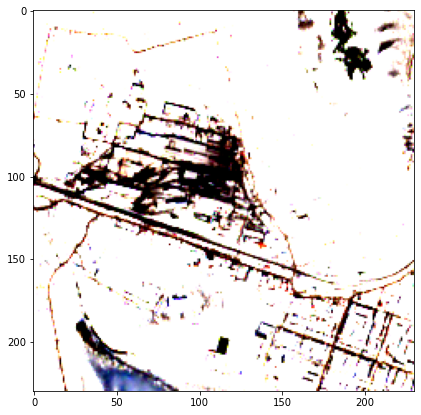

In [594]:
plt.figure(figsize=(7,7))
im = load_features(valid_files[index])[0]
plt.imshow((np.flip(im[:,:,0:3]+np.abs(im.mean())*0+0.5,axis=2)))


In [586]:
valid_files[index]

'E:/Users/sentinel_industry/downloaded_aois/coal\\G113054.pickle'

In [577]:
discard_list.append(valid_files[index])

In [597]:
s=discard_list

In [604]:
for file in discard_list:
    os.remove(file)

In [603]:
# np.save('discard1half',np.array(s))

In [ ]:
# plt.figure(figsize=(7,7))
# for i in valid.skip(index-1).take(1).as_numpy_iterator():
#     print(i[0].shape)
#     im = i[0]
#     plt.imshow((np.flip(im[:,:,0:3]+np.abs(im.mean())*2, axis=2)))

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [24]:
lmodel.predict(valid.take(1))

NameError: name 'lmodel' is not defined

In [577]:
iterator=tf.compat.v1.data.make_one_shot_iterator(valid)

In [578]:
x, y = iterator.get_next()

In [579]:
x=tf.reshape(x,(1, 230,230,4))

In [580]:
tf.nn.softmax(lmodel.predict(x))

1/1 [==============================] - 0s 79ms/step


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.00201979, 0.02055251, 0.9774277 ]], dtype=float32)>

In [584]:
y

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 1])>

In [581]:
lmodel.predict(x)

1/1 [==============================] - 0s 70ms/step


array([[-1.9497141 ,  0.37027735,  4.2322187 ]], dtype=float32)

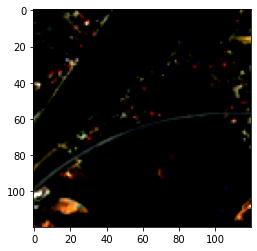

In [583]:
next_element = x
im = resize_rescale_augment(next_element)
plt.imshow(np.flip(im[0,:,:,0:3], axis=2))

In [572]:
y

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 1, 0])>

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    plt.imshow(np.flip(im[0,:,:,0:3], axis=2))
    plt.title(convert_onehot(next_element))

In [ ]:
def convert_onehot(next_element):
    if (next_element[1].numpy() == np.array([0, 0, 1])).all(): return 'no industry'
    elif (next_element[1].numpy() == np.array([0, 1, 0])).all(): return 'steel'
    elif (next_element[1].numpy() == np.array([1, 0, 0])).all(): return 'coal'
    else: return 'not valid'

In [ ]:
next_element[1].numpy().all()

In [ ]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/path/to/file.py")
foo = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = foo
spec.loader.exec_module(foo)

In [ ]:
! PATH